# Global Temperature Predictor - Univariate Time Series

This notebook will dig into the global anual mean temperature dataset, and use time series to predict the next year's global mean temperature.

* https://datahub.io/core/global-temp?ref=hackernoon.com

## Notebook Setup

### Setup
Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

Additionally, if on google colab, then I will need to install my personal repository, `py-learning-toolbox` as a package.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [2]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

### Imports

In [3]:
import datetime
import logging
import pathlib
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
import tensorflow as tf

### Environment
Setting up the environment and analyzing the various information associated with this notebook.

In [4]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-10-06 07:40:56.829364


In [5]:
tf.__version__

'2.13.0'

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

### Global Constants

In [8]:
RANDOM_SEED = 27

WINDOW_SIZE = 14

## Downloading, Analyzing, & Creating Datasets

The data I plan to use comes directly from the raw txt file that was downloaded to the data directory, directly from the website.

* [Global Temperature Time Series](https://datahub.io/core/global-temp?ref=hackernoon.com)

### Download

In [9]:
monthly_data_filepath = pathlib.Path('./data/monthly_csv.csv')
annual_data_url = 'https://pkgstore.datahub.io/core/global-temp/annual_csv/data/a26b154688b061cdd04f1df36e4408be/annual_csv.csv'

In [10]:
data_df = pd.read_csv(annual_data_url)
data_df.tail()

,Source,Year,Mean
269,GISTEMP,1882,-0.1000
270,GCAG,1881,-0.0628
271,GISTEMP,1881,-0.1200
272,GCAG,1880,-0.1148
273,GISTEMP,1880,-0.2000


### Analyze Data

In [11]:
len(data_df)

274

In [12]:
data_df['Source'].value_counts()

Source
GCAG       137
GISTEMP    137
Name: count, dtype: int64

In [13]:
gcag_data_df = data_df[data_df['Source'] == 'GCAG']
gistemp_data_df = data_df[data_df['Source'] == 'GISTEMP']

gcag_data_df.head()

,Source,Year,Mean
0,GCAG,2016,0.9363
2,GCAG,2015,0.8998
4,GCAG,2014,0.7408
6,GCAG,2013,0.6679
8,GCAG,2012,0.6240


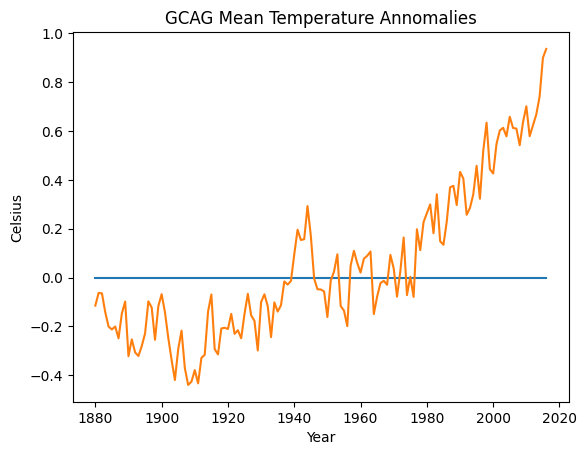

In [14]:
plt.figure()
plt.plot(gcag_data_df['Year'], np.zeros(len(gcag_data_df)))
plt.plot(gcag_data_df['Year'], gcag_data_df['Mean'])
plt.title('GCAG Mean Temperature Annomalies')
plt.ylabel('Celsius')
plt.xlabel('Year');

Text(0.5, 0, 'Year')

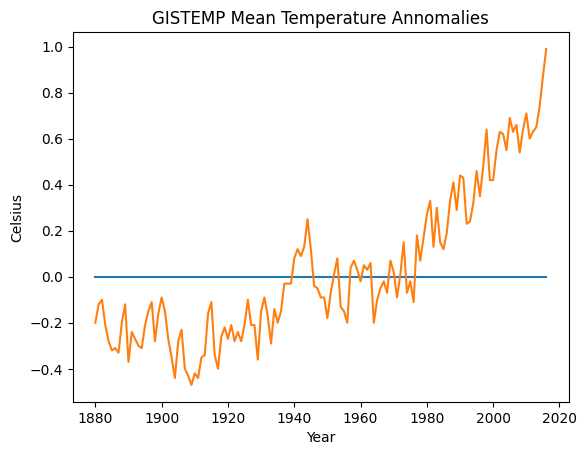

In [15]:
plt.figure()
plt.plot(gistemp_data_df['Year'], np.zeros(len(gistemp_data_df)))
plt.plot(gistemp_data_df['Year'], gistemp_data_df['Mean'])
plt.title('GISTEMP Mean Temperature Annomalies')
plt.ylabel('Celsius')
plt.xlabel('Year')

### Split Data

In [16]:
# Constants
train_split_percentile = 0.85

In [17]:
data = gistemp_data_df['Mean'].to_numpy()
split_index = int(len(data) * train_split_percentile)
train_data, test_data = data[:split_index], data[split_index:]

len(train_data), len(test_data)

(116, 21)

### Create Datasets

In [18]:
train_dataset = ml_toolbox.preprocessing.timeseries.make_windowed_dataset(train_data, window_size=WINDOW_SIZE)
test_dataset = ml_toolbox.preprocessing.timeseries.make_windowed_dataset(test_data, window_size=WINDOW_SIZE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>)

### Checking Dataset

In [19]:
sample_features, sample_labels = next(iter(train_dataset.take(1)))

sample_features[:3], sample_labels[:3]

(<tf.Tensor: shape=(3, 14), dtype=float64, numpy=
 array([[0.99, 0.87, 0.74, 0.65, 0.63, 0.6 , 0.71, 0.64, 0.54, 0.66, 0.63,
         0.69, 0.55, 0.62],
        [0.87, 0.74, 0.65, 0.63, 0.6 , 0.71, 0.64, 0.54, 0.66, 0.63, 0.69,
         0.55, 0.62, 0.63],
        [0.74, 0.65, 0.63, 0.6 , 0.71, 0.64, 0.54, 0.66, 0.63, 0.69, 0.55,
         0.62, 0.63, 0.55]])>,
 <tf.Tensor: shape=(3, 1), dtype=float64, numpy=
 array([[0.63],
        [0.55],
        [0.42]])>)

## Experiments

I am going to perform a handful of experiments to see if I can predict the global temp.

* Experiment-0 (Baseline): Naive Model
* Experiment-1: Feed Forward Model
* Experiment-2: LSTM
* Experiment-3: Conv1D

### Constants

In [20]:
INPUT_SIZE = WINDOW_SIZE
OUTPUT_SIZE = 1

### Experiment-0: Naive 

In [21]:
# Constants
model_0_name = 'model_0_naive'

In [22]:
naive_forecast = test_data[:-1]

In [23]:
model_0_results = ml_toolbox.analysis.regression.generate_prediction_metrics(test_data[1:], naive_forecast, name=model_0_name)
model_0_results

RegressionPredictionMetrics(mae=0.0785, mse=0.009695001, rmse=0.09846319, mape=45.1159, mase=0.9943333, huber=0.0048475005, name='model_0_naive')

### Experiment-1: Feed Forward Network

In [24]:
# Constants
model_1_name = 'model_1_ffn'

In [25]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SIZE,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='relu'),
], name=model_1_name)

model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
                metrics=['mse', 'mae'])

model_1_history = model_1.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    verbose=0)

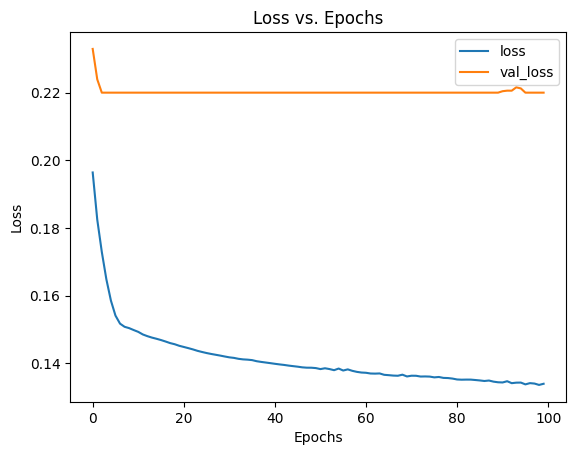

In [26]:
ml_toolbox.analysis.history.plot_history(model_1_history, 'loss')

In [27]:
model_1_results = ml_toolbox.analysis.regression.generate_prediction_metrics_from_dataset_and_model(test_dataset, model_1)
model_1_results

RegressionPredictionMetrics(mae=0.22, mse=0.055057142, rmse=0.22, mape=100.0, mase=nan, huber=0.027528571, name='model_1_ffn')

### Experiment-2: LSTM

In [28]:
# Constants
model_2_name = 'model_2_lstm'

In [29]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SIZE,)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1), name='reshape_layer'),
    tf.keras.layers.LSTM(32, kernel_regularizer=tf.keras.regularizers.l1()),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='relu'),
], name=model_2_name)

model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                metrics=['mse', 'mae'])

model_2_history = model_2.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    verbose=0)

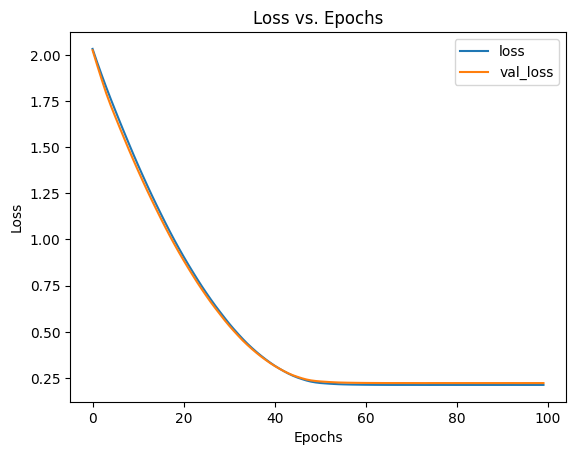

In [30]:
ml_toolbox.analysis.history.plot_history(model_2_history, 'loss')

In [31]:
model_2_results = ml_toolbox.analysis.regression.generate_prediction_metrics_from_dataset_and_model(test_dataset, model_2)
model_2_results

RegressionPredictionMetrics(mae=0.22, mse=0.055057142, rmse=0.22, mape=100.0, mase=nan, huber=0.027528571, name='model_2_lstm')

### Experiment-3: Conv1D

In [32]:
# Constants
model_3_name = 'model_3_conv'

In [33]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SIZE,)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1), name='reshape_layer'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='relu'),
], name=model_3_name)

model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
                metrics=['mse', 'mae'])

model_3_history = model_3.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    verbose=0)

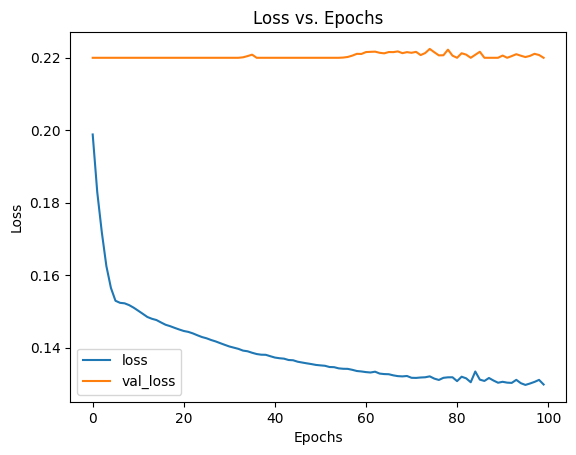

In [34]:
ml_toolbox.analysis.history.plot_history(model_3_history, 'loss')

In [35]:
model_3_results = ml_toolbox.analysis.regression.generate_prediction_metrics_from_dataset_and_model(test_dataset, model_3)
model_3_results

RegressionPredictionMetrics(mae=0.22, mse=0.055057142, rmse=0.22, mape=100.0, mase=nan, huber=0.027528571, name='model_3_conv')